# Tumor detection using Markov Random Fields (MRF) :

- Markov Random Field is a graphical model. It can be used for various topics, here we use MRF to do image segmentation on brain MRI. We will model the pixels as observed variables and the true labeling of each pixel as hidden variables, the hidden variables are dependent on the corresponding pixel and on the neighboring hidden variables (this is the Markov assumption), thus the graphical model result in an Undirected Graph. The segmentation problem becomes the maximization of a joint distribution of all variables, the Markov assumption allows a simple factorization of this distribution, the joint probability can be interpreted as a Gibbs distribution. If we model the color distribution as a Gaussian for each pixel we could solve the problem equivalently by maximizing the log probability which leads to a minimization problem of the form : $\operatorname*{argmin}_X U_1(X) + U_2(X)$. After a pseudo random initialization phase with four classes, we get around 9,78% decrease in the tumor size.

- Les Champs de Markov Aléatoires sont un exemple de modèles graphiques. Ils peuvent être utilisés dans différents contextes, ici nous les utilisons pour résoudre le problème de segmentation de tumeurs. Cette méthode modélise l'image comme étant un graphe non orienté, les pixels sont perçus comme des variables observées et les labels de pixels (non connus initialement) sont vus comme étant des variables cachées, chaque variable cachée ne dépend que de son voisinage (c'est cela l'hypothèse markovienne), le problème de segmentation peut alors être réécrit sous la forme d'une maximisation de probabilité conjointe sur toutes les variables. L'hypothèse de Markov permet une factorisation plutôt simple de cette distribution, ainsi on peut voir le problème comme une maximisation d'une sorte d'énergie dite de Gibbs. De plus si on suppose une distribution Gaussienne des couleurs pour chaque pixel on pourra réécrire le problème comme une maximisation : $\operatorname*{argmin}_X U_1(X) + U_2(X)$. Ici nous initialisons cette méthode de manière pseudo-aléatoire, c'est-à-dire que nous mettons 25 pixels initialement sur la tumeur, puis le reste des variables cachées est tiré aléatoirement. Nous trouvons que la tumeur a rétréci de 9,78%.

In [1]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from skimage import measure
from collections import Counter
import random
random.seed(5)
np.random.seed(5)

## Loading medical images

In [2]:
IRMcoupe17_t1 = Image.open('./images/IRMcoupe17-t1.jpg')
IRMcoupe17_t2 = Image.open('./images/IRMcoupe17-t2.jpg')

IRMcoupe17_t1 = np.array(IRMcoupe17_t1)
IRMcoupe17_t2 = np.array(IRMcoupe17_t2)

## Visualizing the images

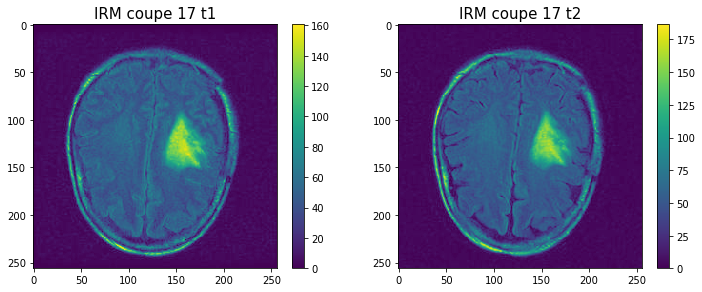

In [3]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.imshow(IRMcoupe17_t1)
plt.title('IRM coupe 17 t1', fontsize=15)
plt.colorbar(shrink=0.9)

plt.subplot(1, 2, 2)
plt.imshow(IRMcoupe17_t2)
plt.title('IRM coupe 17 t2', fontsize=15)
plt.colorbar(shrink=0.9)

plt.show()

## Visualization of the histograms

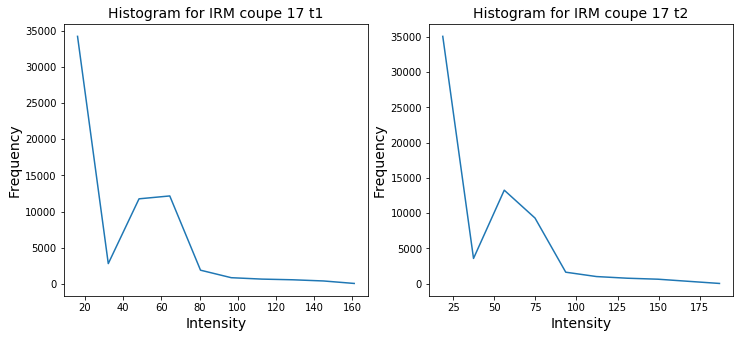

In [4]:
frequencies1, intensities1 = np.histogram(IRMcoupe17_t1)
frequencies2, intensities2 = np.histogram(IRMcoupe17_t2)

# Make both arrays of the same size
intensities1 = intensities1[1:]
intensities2 = intensities2[1:]

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(intensities1, frequencies1)
plt.title("Histogram for IRM coupe 17 t1", fontsize=14)
plt.xlabel("Intensity", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(intensities2, frequencies2)
plt.title("Histogram for IRM coupe 17 t2", fontsize=14)
plt.xlabel("Intensity", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

plt.show()

## Pseudo Random Initialization

In [5]:
X_IRMcoupe17_t1 = np.ndarray(IRMcoupe17_t1.shape)
X_IRMcoupe17_t2 = np.ndarray(IRMcoupe17_t2.shape)

nbLabels = 4
labels = list(range(nbLabels))

# We initialize the hidden variables randomly except for the tumor label
# thet is put on 25 pixels inside the tumor region ...
for i in range(IRMcoupe17_t1.shape[0]):
    for j in range(IRMcoupe17_t1.shape[1]):
        if i in range(120,125) and j in range(170, 175):
            X_IRMcoupe17_t1[i,j] = nbLabels - 1
            X_IRMcoupe17_t2[i,j] = nbLabels - 1
        else:
            X_IRMcoupe17_t1[i,j] = random.sample(population=labels[:-1], k=1)[0]
            X_IRMcoupe17_t2[i,j] = random.sample(population=labels[:-1], k=1)[0]

## Initialization Visualization

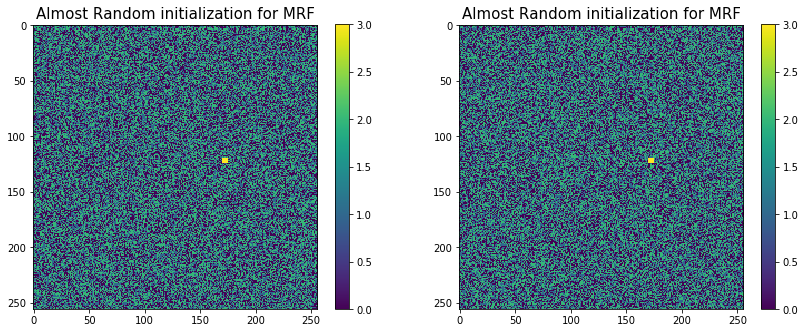

In [6]:
plt.figure(figsize=(14,7))
plt.subplot(1, 2, 1)
plt.imshow(X_IRMcoupe17_t1)
plt.title('Almost Random initialization for MRF', fontsize=15)
plt.colorbar(shrink=0.75)

plt.subplot(1, 2, 2)
plt.imshow(X_IRMcoupe17_t2)
plt.title('Almost Random initialization for MRF', fontsize=15)
plt.colorbar(shrink=0.75)

## Defining Auxilary Functions that will serve to minimize the Gibbs Energy

In [7]:
def Neighbors(i, j, iMAX, jMAX):
    N = []
    if i - 1 >= 0:   N.append((i - 1,j))
    if j - 1 >= 0:   N.append((i,j - 1))
    if i + 1 < iMAX: N.append((i + 1,j))
    if j + 1 < jMAX: N.append((i,j + 1))
    
    if i - 1 >= 0 and j - 1 >= 0:     N.append((i - 1,j - 1))
    if i - 1 >= 0 and j + 1 < jMAX:   N.append((i - 1,j + 1))
    if i + 1 < iMAX and j - 1 >= 0:   N.append((i + 1,j - 1))
    if i + 1 < iMAX and j + 1 < jMAX: N.append((i + 1,j + 1))

    return N


def Uij(X, i, j, label):
    uij = 0
    
    # Several values for beta have been tested 0.5 seems to give the best answer
    beta = 0.9
    for (ii, jj) in Neighbors(i, j, X.shape[0], X.shape[1]):
        if label != X[ii,jj]:
            uij += beta
    return uij

    
def U1(img, mu, sigma):
    return 0.5 * np.power((img - mu)/sigma, 2)


def U2(X, label):
    U = np.ndarray(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            U[i,j] = Uij(X, i, j, label)
    return U

def muAndSigma(img, X, label):
    pixelsLabel = []
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if X[i,j] == label:
                pixelsLabel.append(img[i,j])
    
    if len(pixelsLabel) == 0:
        return None, None
        # raise Exception('No pixels found for this label : ' + str(label))

    mu  = np.array(pixelsLabel).mean()
    std = np.array(pixelsLabel).std()
    return mu, std


def minimizeEnergy(U_s):
    X = np.ndarray(U_s[0].shape)
    for i in range(U_s[0].shape[0]):
        for j in range(U_s[0].shape[1]):
            X[i,j] = np.argmin([U_s[l][i,j] for l in labels]) # U_s[:,i,j]
    return X


def MRF(IMG, X, labels, ITER_MAX=50):
    diff = 50000
    iterations = 0
    Xs = [X.copy()]

    # Loop until there is no more than 1000 pixels changing 
    while diff > 1000 and iterations < ITER_MAX:
        Us = []
        iterations += 1    
        for label in labels:
            mu, sigma = muAndSigma(IMG, X, label)
            Us.append(U1(IMG, mu, sigma) + U2(X, label))

        X = minimizeEnergy(Us)
        Xs.append(X.copy())

        diff = sum([Xs[-1][ii, jj] != Xs[-2][ii, jj] for ii in range(X.shape[0]) for jj in range(X.shape[1])])
        print('Iteration {:>3}, pixels changing : {:>5}'.format(iterations, diff))
    return Xs
    
    

## Computing MRF Segmentation for both MRIs 

In [8]:
print('First IRM')
result_1 = MRF(IRMcoupe17_t1, X_IRMcoupe17_t1, labels)

print('\nSecond IRM After 4 month')
result_2 = MRF(IRMcoupe17_t2, X_IRMcoupe17_t2, labels)


First IRM
Iteration   1, pixels changing : 43739
Iteration   2, pixels changing : 27717
Iteration   3, pixels changing : 16808
Iteration   4, pixels changing : 11030
Iteration   5, pixels changing :  7569
Iteration   6, pixels changing :  5587
Iteration   7, pixels changing :  4157
Iteration   8, pixels changing :  3288
Iteration   9, pixels changing :  2717
Iteration  10, pixels changing :  2237
Iteration  11, pixels changing :  1880
Iteration  12, pixels changing :  1604
Iteration  13, pixels changing :  1376
Iteration  14, pixels changing :  1191
Iteration  15, pixels changing :  1074
Iteration  16, pixels changing :   985

Second IRM After 4 month
Iteration   1, pixels changing : 43760
Iteration   2, pixels changing : 28254
Iteration   3, pixels changing : 17550
Iteration   4, pixels changing : 11469
Iteration   5, pixels changing :  8039
Iteration   6, pixels changing :  6452
Iteration   7, pixels changing :  5017
Iteration   8, pixels changing :  3934
Iteration   9, pixels changi

## Visualizing the segmentation over iterations

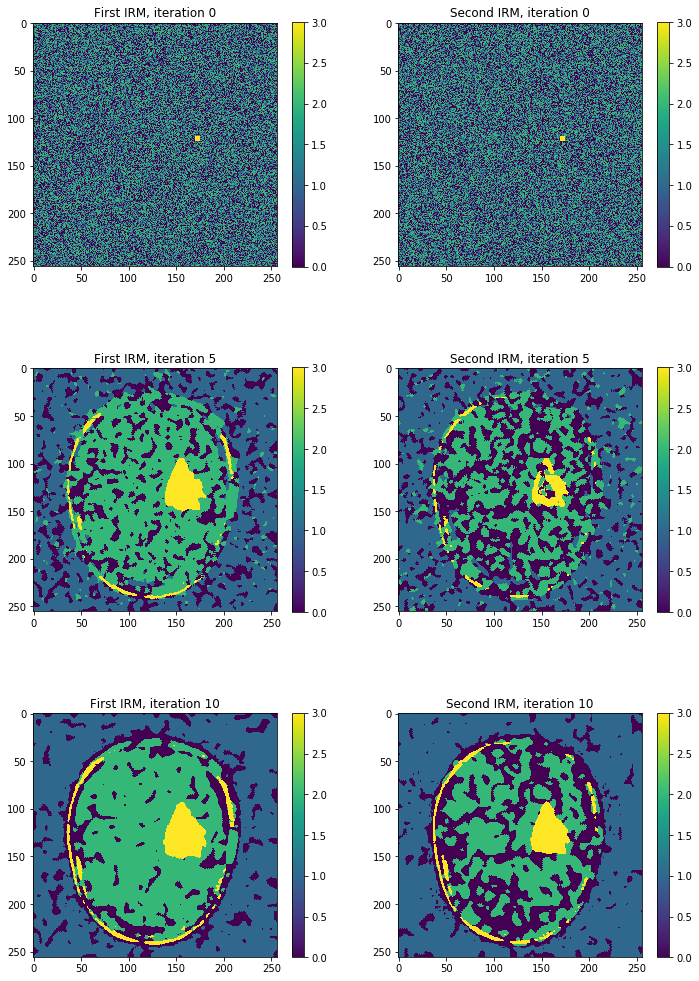

In [9]:
nb = min(len(result_1), len(result_2)) // 5
plt.figure(figsize=(12, 6 * nb))

for i in range(1, nb + 1):
    plt.subplot(nb, 2, 2 * i - 1)
    plt.imshow(result_1[5 * (i-1)])
    plt.title('First IRM, iteration {}'.format(5 * (i-1)))
    plt.colorbar(shrink=0.85)

    plt.subplot(nb, 2, 2 * i)
    plt.imshow(result_2[5 * (i-1)])
    plt.title('Second IRM, iteration {}'.format(5 * (i-1)))
    plt.colorbar(shrink=0.85)



## Binarizing the results of the last iteration

Text(0.5,1,'Second IRM')

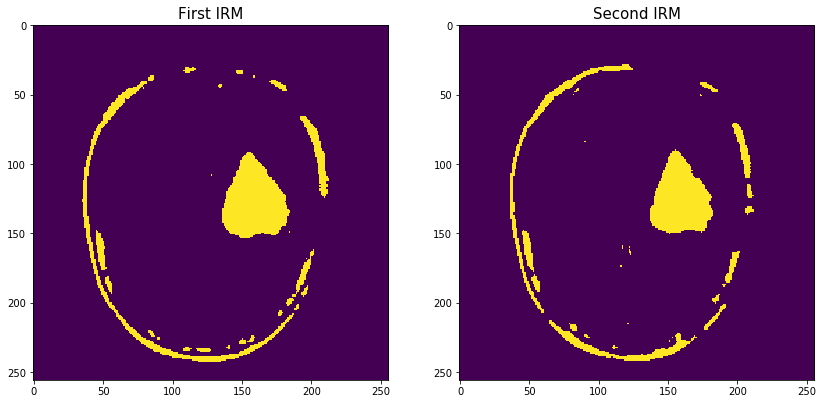

In [10]:
IRMcoupe17_t1_Binarized = result_1[-1].copy()
IRMcoupe17_t1_Binarized[IRMcoupe17_t1_Binarized != 3] = 0

IRMcoupe17_t2_Binarized = result_2[-1].copy()
IRMcoupe17_t2_Binarized[IRMcoupe17_t2_Binarized != 3] = 0

plt.figure(figsize=(14,7))
plt.subplot(1, 2, 1)
plt.imshow(IRMcoupe17_t1_Binarized)
plt.title('First IRM', fontsize=15)

plt.subplot(1, 2, 2)
plt.imshow(IRMcoupe17_t2_Binarized)
plt.title('Second IRM', fontsize=15)


## Finding Tumor contour using labeling and computing the growth factor (%)

In [11]:
# Doing the labeling
IRMcoupe17_t1_Labeled = measure.label(IRMcoupe17_t1_Binarized)
IRMcoupe17_t2_Labeled = measure.label(IRMcoupe17_t2_Binarized)

# Here we assume that the tumor is the second element
# in term of area after the background ...

# Getting the label of tumor first IRM
count = Counter(IRMcoupe17_t1_Labeled.ravel())
tumor1_label, _ = count.most_common(2)[1]

# Getting the label of tumor second IRM
count = Counter(IRMcoupe17_t2_Labeled.ravel())
tumor2_label, _ = count.most_common(2)[1]

# Initializing tumor images
tumor1 = np.zeros(IRMcoupe17_t1.shape)
tumor2 = np.zeros(IRMcoupe17_t1.shape)

for i in range(IRMcoupe17_t1.shape[0]):
    for j in range(IRMcoupe17_t1.shape[1]):
        if IRMcoupe17_t1_Labeled[i][j] == tumor1_label:
            tumor1[i][j] = 1

        if IRMcoupe17_t2_Labeled[i][j] == tumor2_label:
            tumor2[i][j] = 1
        

# Computing thze growth factor ...
tumorSizeBefore = np.sum(tumor1)
tumorSizeAfter  = np.sum(tumor2)
growthFactor = 100*(tumorSizeAfter - tumorSizeBefore) / tumorSizeBefore

IRMcoupe17_t1_Diagnose = IRMcoupe17_t1.copy()
IRMcoupe17_t2_Diagnose = IRMcoupe17_t2.copy()

# Finding the tumor contour
for i, j in measure.find_contours(tumor1, level=0)[0]:
    IRMcoupe17_t1_Diagnose[int(i)][int(j)] = 200

for i, j in measure.find_contours(tumor2, level=0)[0]:
    IRMcoupe17_t2_Diagnose[int(i)][int(j)] = 200

## Visualization

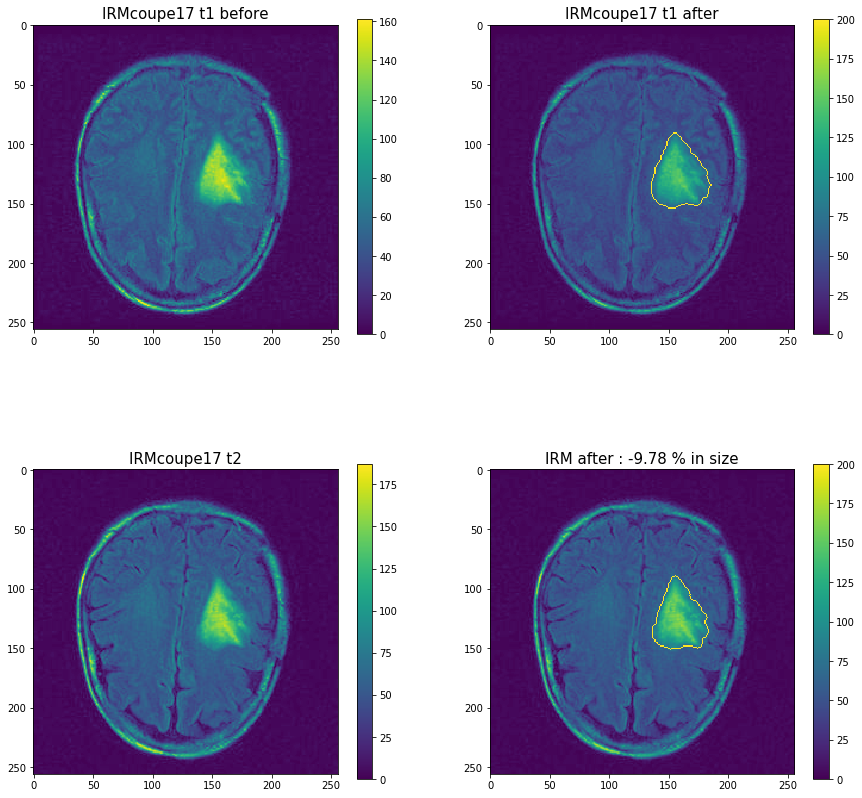

In [12]:
plt.figure(figsize=(15,15))

plt.subplot(2, 2, 1)
plt.imshow(IRMcoupe17_t1)
plt.title('IRMcoupe17 t1 before', fontsize=15)
plt.colorbar(shrink=0.85)

plt.subplot(2, 2, 2)
plt.imshow(IRMcoupe17_t1_Diagnose)
plt.title('IRMcoupe17 t1 after', fontsize=15)
plt.colorbar(shrink=0.85)


plt.subplot(2, 2, 3)
plt.imshow(IRMcoupe17_t2)
plt.title('IRMcoupe17 t2', fontsize=15)
plt.colorbar(shrink=0.85)

plt.subplot(2, 2, 4)
plt.imshow(IRMcoupe17_t2_Diagnose)
plt.title('IRM after : {0:.2f} % in size'.format(growthFactor), fontsize=15)
plt.colorbar(shrink=0.85)

plt.show()